# DS 542 Homework 2

In this homework, you will use the image model Stable Diffusion to reproduce a new photo that is not in its training data.


## Instructions

1. Make a copy of this notebook (e.g. File -> Save a Copy in Drive).
2. Filling in the necessary code for each problem below, and run your notebook to show that your code works.
3. Save your notebook (Colab does this automatically, must be done for VS Code).
4. Upload your notebook to Gradescope.

## Module Setup

In [1]:
!pip install -q keras-core --upgrade
!pip install -q keras-cv --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 37.9 MB/s eta 0:00:00


In [2]:
import os

os.environ["KERAS_BACKEND"] = "torch"

In [28]:
import imageio.v2 as imageio
import keras_core as keras
import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import skimage
import torch
import tqdm

## GPU Setup

In [4]:
# autodetect GPU availability in Google Colab.

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
print("DEVICE", DEVICE)
torch.set_default_device(DEVICE)

torch.tensor([[0.0, 0.1, 0.4, 0.3, 0.5]])

DEVICE cuda:0


tensor([[0.0000, 0.1000, 0.4000, 0.3000, 0.5000]], device='cuda:0')

## Load and Test Stable Diffusion

In [5]:
model = keras_cv.models.StableDiffusion(img_width=256, img_height=256)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [6]:
def plot_images(images):
    # Original version from https://colab.research.google.com/gist/jbischof/ef9dde655d1c230b66abaf9eb54e1ad0/stable-diffusion-keras-core-jax.ipynb
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()

    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

198180272/198180272 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


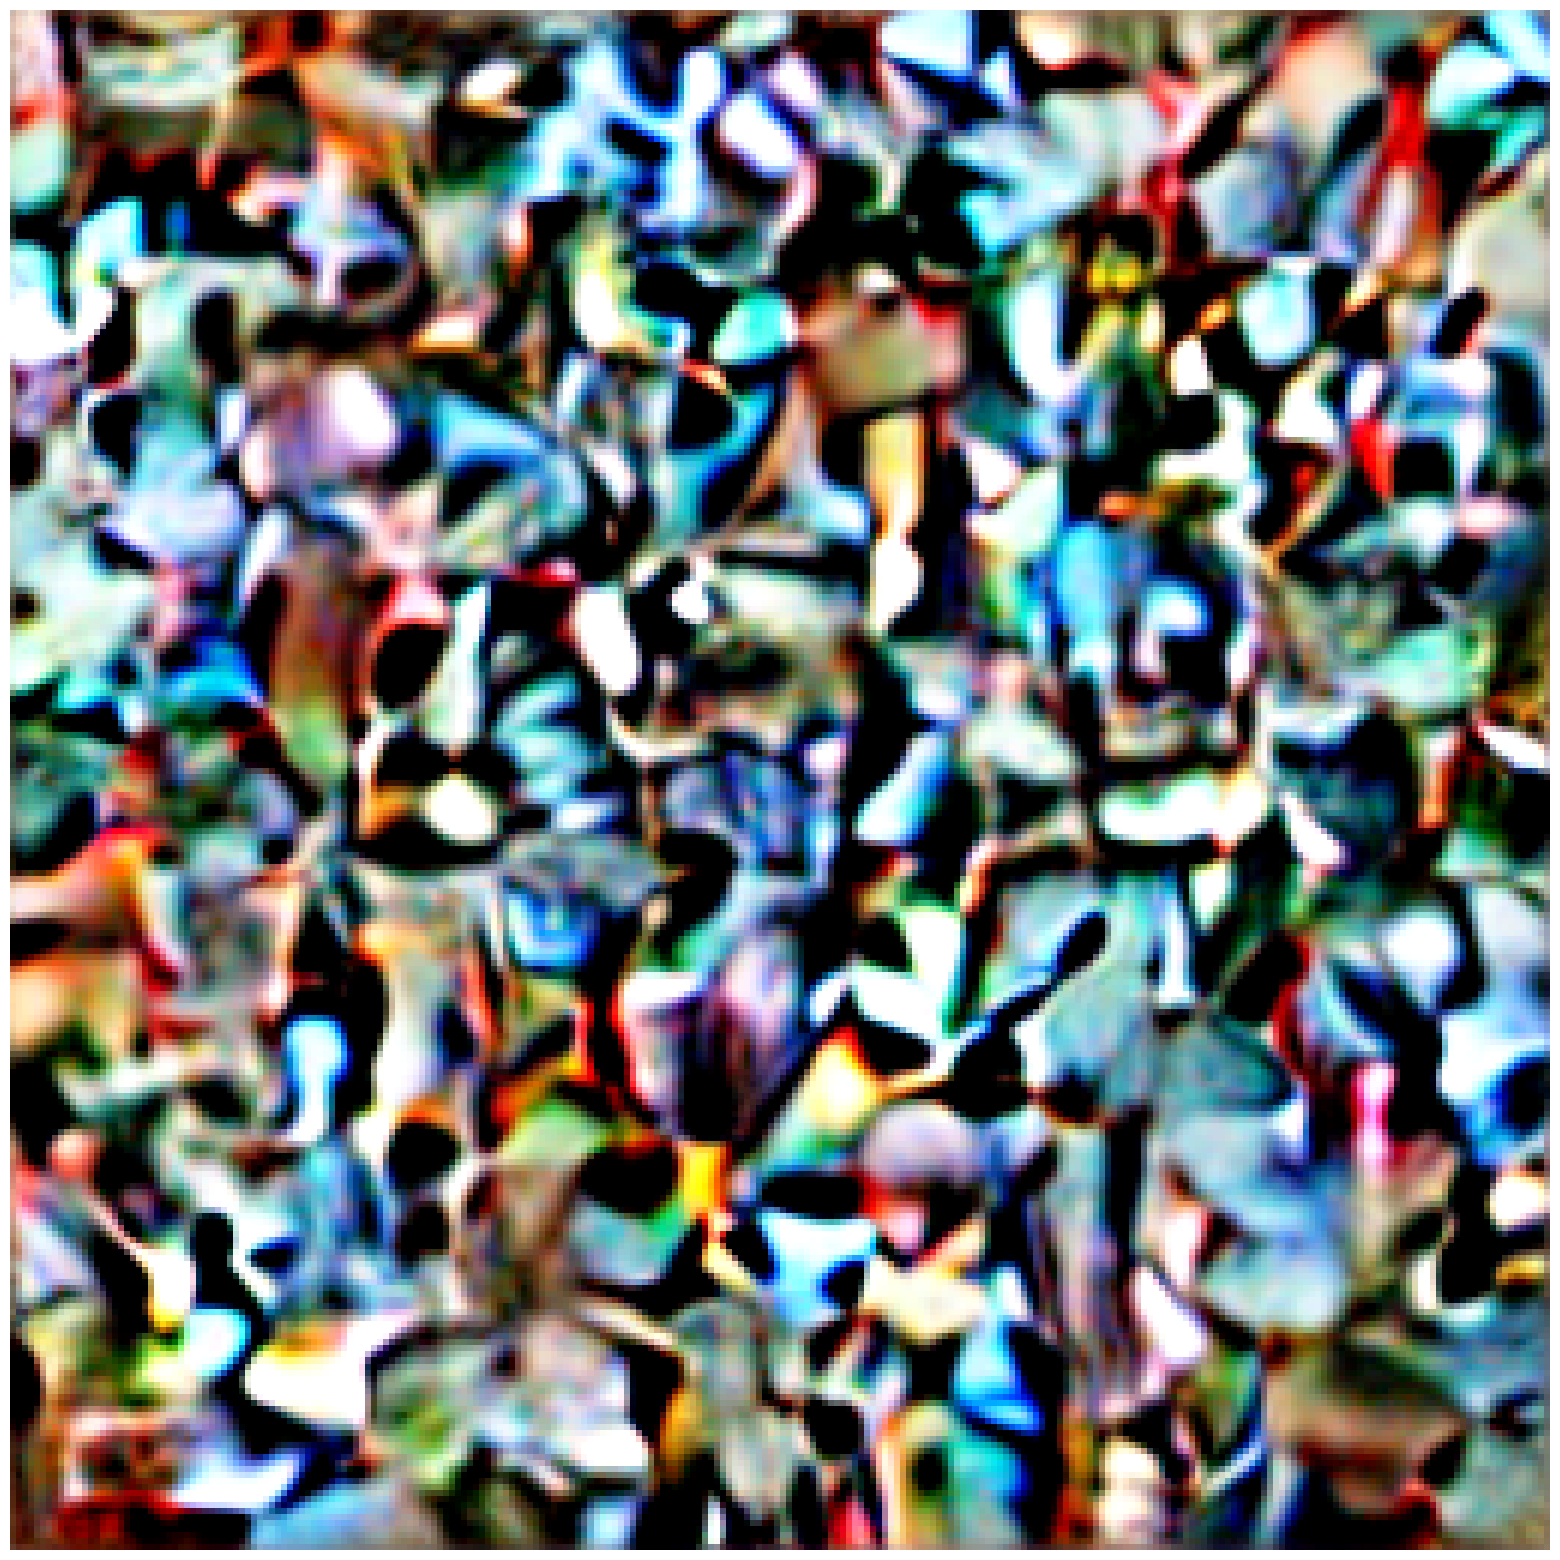

In [7]:
# convert Stable Diffusion latent code into an image with [0-1] color values.

def decode_latent(latent):
    decoded = model.decoder.forward(latent)

    # remap output range from zero centered to roughly [0,1]
    decoded = ((decoded + 1) / 2) # * 255

    # really limit the output range to [0,1]
    decoded = torch.clamp(decoded, 0.0, 1.0)

    return decoded

random_latent = torch.randn(1, 32, 32, 4, device=DEVICE)
random_latent_image = decode_latent(random_latent)
plot_images(random_latent_image)

## Problem 1: Load Target Image

1. Take a photo that is personal to you.
    * Some part of the subject must be personal to you. This could be a selfie, a handwritten version of your name (other languages/scripts welcome), or even a picture of your hand.
    * It must include something indicating the current date (e.g. September 2025) such as writing the date or showing the current page of the Daily Free Press.
    * Resize this image to 256x256 pixels.
    * Do this image prep however you like - it does not need to be in the notebook.
2. Load the image as a variable `target_image` in this notebook and normalize it as follows.
    * `imageio.imread` will be useful for the initial load.
    * `target_image` should be a [PyTorch tensor](https://docs.pytorch.org/docs/stable/tensors.html) with data type `torch.float32`.
    * The dimensions should be 1x256x256x3. The one is for a "batch size" -- just this one image. The three is for red/green/blue color channels. PyTorch has view and reshaping functions similar to NumPy.


In [14]:
# YOUR CHANGES HERE
from google.colab import files

uploaded = files.upload()

# load your photo into the variable target_image_original variable

target_image_original = "deepl.jpg"




Saving deepl.jpg to deepl.jpg


In [33]:
# this code might be helpful to get your image into target_image
# in the right format
from PIL import Image
# YOUR CHANGES HERE
target_image = target_image_original
target_image = Image.open(target_image)
target_image = np.array(target_image)
if target_image.dtype == np.uint8:
    target_image = target_image / 255.0
target_image = torch.tensor(target_image, dtype=torch.float32)

target_image = target_image.view(1, *target_image.shape)


SHAPE torch.Size([1, 256, 256, 3]) MIN 0.0 MAX 1.0 DTYPE torch.float32


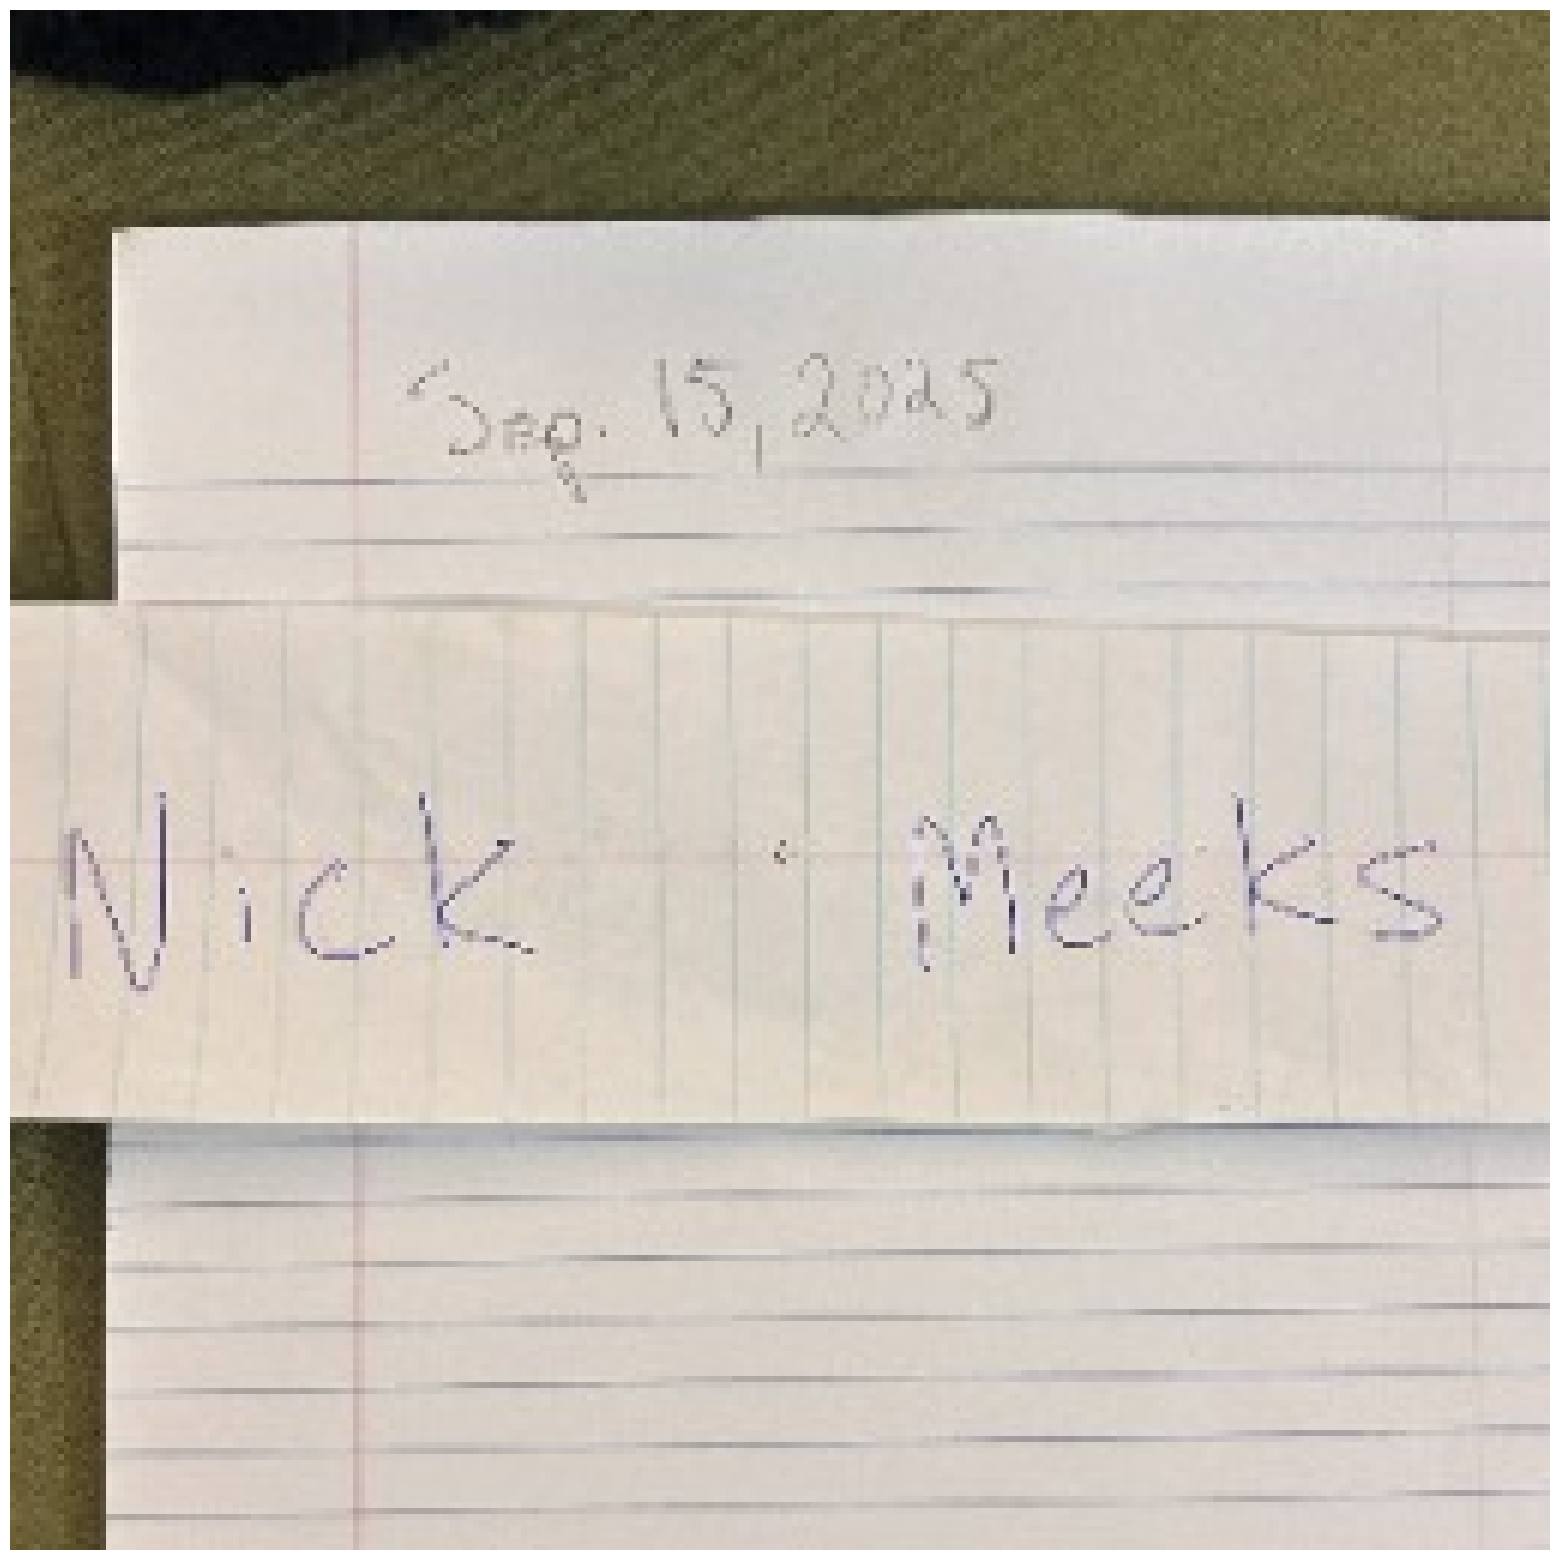

In [34]:
# plot your image to make sure

print("SHAPE", target_image.shape,
      "MIN", target_image.min().item(),
      "MAX", target_image.max().item(),
      "DTYPE", target_image.dtype)
plot_images(target_image)

## Problem 2: Pick a Loss Function

1. Implement the function `compute_loss` below that takes in an output image and a target image.
    * If the images are identical, the output should be zero.
    * If the images are different, the output should be positive.
    * The computation should be differentiable.


In [35]:
# YOUR CHANGES HERE

def compute_loss(output, target):
    # YOUR CHANGES HERE
    loss = torch.nn.functional.mse_loss(output, target)
    return loss


In [36]:
# sanity check your loss function

random_latent_loss = compute_loss(random_latent_image, target_image)
print("RANDOM LATENT LOSS", random_latent_loss.item())

target_loss = compute_loss(target_image, target_image)
print("TARGET IMAGE LOSS", target_loss.item())

RANDOM LATENT LOSS 0.25386470556259155
TARGET IMAGE LOSS 0.0


## Problem 3: Make Stable Diffusion Output Your Image

The following code uses a simplified PyTorch training loop to optimize a Stable Diffusion latent code to reproduce your image.
**Make whatever changes that you deem necessary** so that it finds a latent code encoding an image very similar to your original image.

Make sure to check the output image really matches!
The cells following the training loop will help you check how fast progress was made and the quality of your result.

In [52]:
# YOUR CHANGES HERE

latent = torch.randn(1, 32, 32, 4, requires_grad=True)

# UPPER BOUND ON NUMBER OF OPTIMIZATION STEPS
steps=1000

decoded_images = []
optimizer = torch.optim.Adam([latent], lr=1e-1)
for step in tqdm.tqdm(range(steps), desc="Optimizing latents"):
    optimizer.zero_grad()
    latent.retain_grad()

    decoded_image = decode_latent(latent)
    # save a copy of the image that is disconnected from gradient tracking.
    decoded_images.append(decoded_image.detach())

    # compute an appropriate loss function to guide the output to match your target image.

    loss = compute_loss(decoded_image, target_image)

    # compute gradients with backward pass
    loss.backward()

    # optimize the latent code based on the gradients.
    optimizer.step()

    # occasionally print out loss value
    if (step + 1) % (steps // 10) == 0:
        print("")
        print("LOSS", loss.item())

    # stop when loss is small.
    # CHANGE THIS THRESHOLD if not appropriate for your loss function.
    if loss.item() < 1e-4:
        break

print("")

overall_loss = compute_loss(decoded_image, target_image)
print("OVERALL LOSS", overall_loss.item())

decoded_images = torch.cat(decoded_images, dim=0)
num_images = decoded_images.shape[0]
print("NUM IMAGES", num_images)


Optimizing latents:  10%|█         | 100/1000 [00:46<06:50,  2.19it/s]


LOSS 0.0016535924514755607


Optimizing latents:  20%|██        | 200/1000 [01:30<05:55,  2.25it/s]


LOSS 0.001105575356632471


Optimizing latents:  30%|███       | 300/1000 [02:16<05:15,  2.22it/s]


LOSS 0.0008038912783376873


Optimizing latents:  40%|████      | 400/1000 [03:01<04:29,  2.22it/s]


LOSS 0.0006054943660274148


Optimizing latents:  50%|█████     | 500/1000 [03:46<03:47,  2.20it/s]


LOSS 0.0004962005186825991


Optimizing latents:  60%|██████    | 600/1000 [04:31<02:59,  2.23it/s]


LOSS 0.0004404501523822546


Optimizing latents:  70%|███████   | 700/1000 [05:16<02:15,  2.21it/s]


LOSS 0.00040964328218251467


Optimizing latents:  80%|████████  | 800/1000 [06:01<01:31,  2.19it/s]


LOSS 0.0003945268108509481


Optimizing latents:  90%|█████████ | 900/1000 [06:46<00:44,  2.23it/s]


LOSS 0.00037328663165681064


Optimizing latents: 100%|██████████| 1000/1000 [07:31<00:00,  2.21it/s]


LOSS 0.000364758656360209

OVERALL LOSS 0.000364758656360209
NUM IMAGES 1000


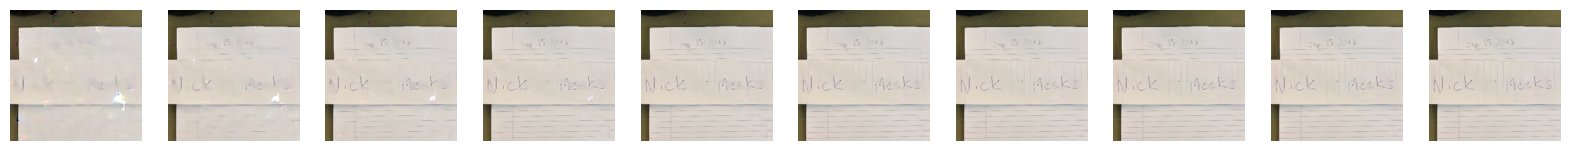

In [53]:
# plot 10 of the images to show the progress
plot_images(decoded_images[num_images//10-1::(num_images+9)//10,:,:])


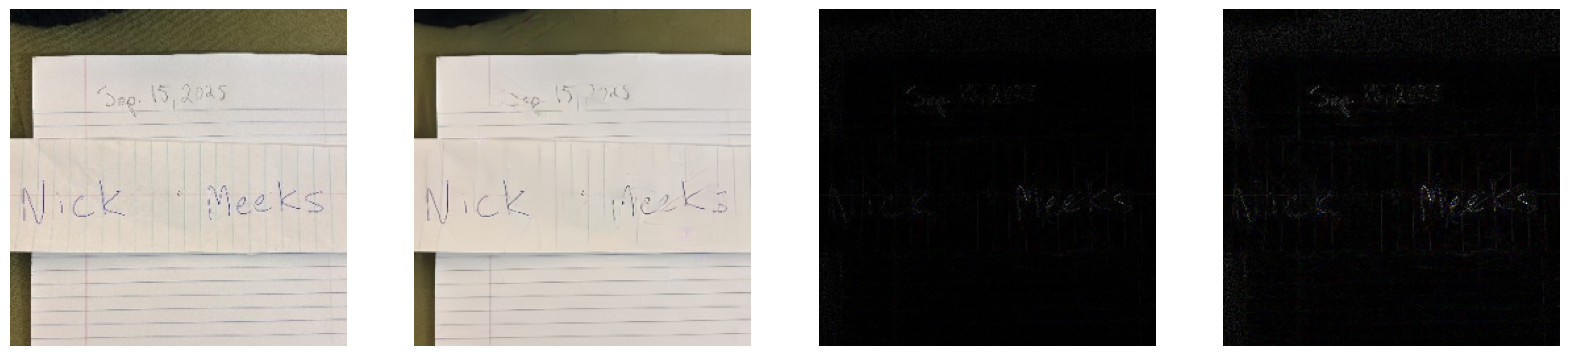

In [54]:
last_image = decoded_image[-1:,:,:,:]

diff_image = (target_image - last_image).abs()

comparison_images = torch.cat([target_image, last_image, diff_image, diff_image / diff_image.max()], dim=0)
plot_images(comparison_images)